## 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이타셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


* CRIM: 지역별 범죄 발생률  
* ZN: 25,000평방피트를 초과하는 거주 지역의 비율
* NDUS: 비상업 지역 넓이 비율
* CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
* NOX: 일산화질소 농도
* RM: 거주할 수 있는 방 개수
* AGE: 1940년 이전에 건축된 소유 주택의 비율
* DIS: 5개 주요 고용센터까지의 가중 거리
* RAD: 고속도로 접근 용이도
* TAX: 10,000달러당 재산세율
* PTRATIO: 지역의 교사와 학생 수 비율
* B: 지역의 흑인 거주 비율
* LSTAT: 하위 계층의 비율
* MEDV: 본인 소유의 주택 가격(중앙값)

* 각 컬럼별로 주택가격에 미치는 영향도를 조사

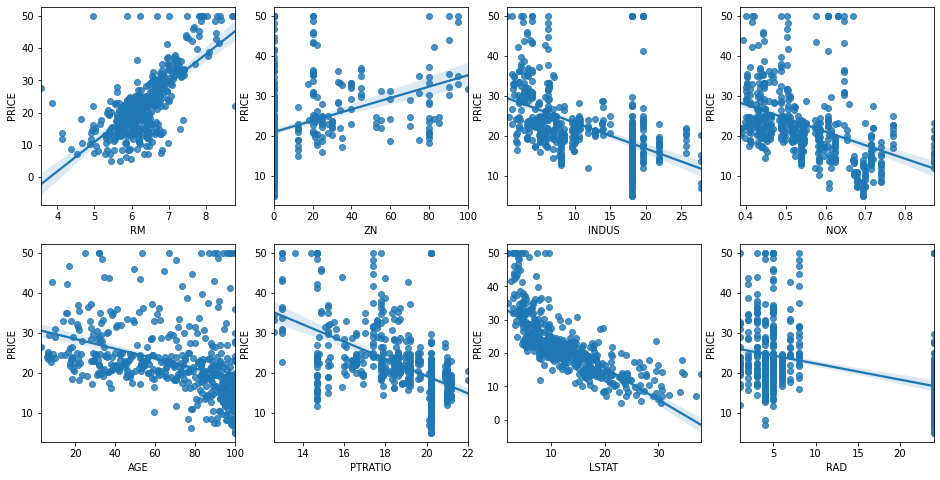

In [2]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i , feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='PRICE',data=bostonDF , ax=axs[row][col])

<AxesSubplot:title={'center':'Correlation'}>

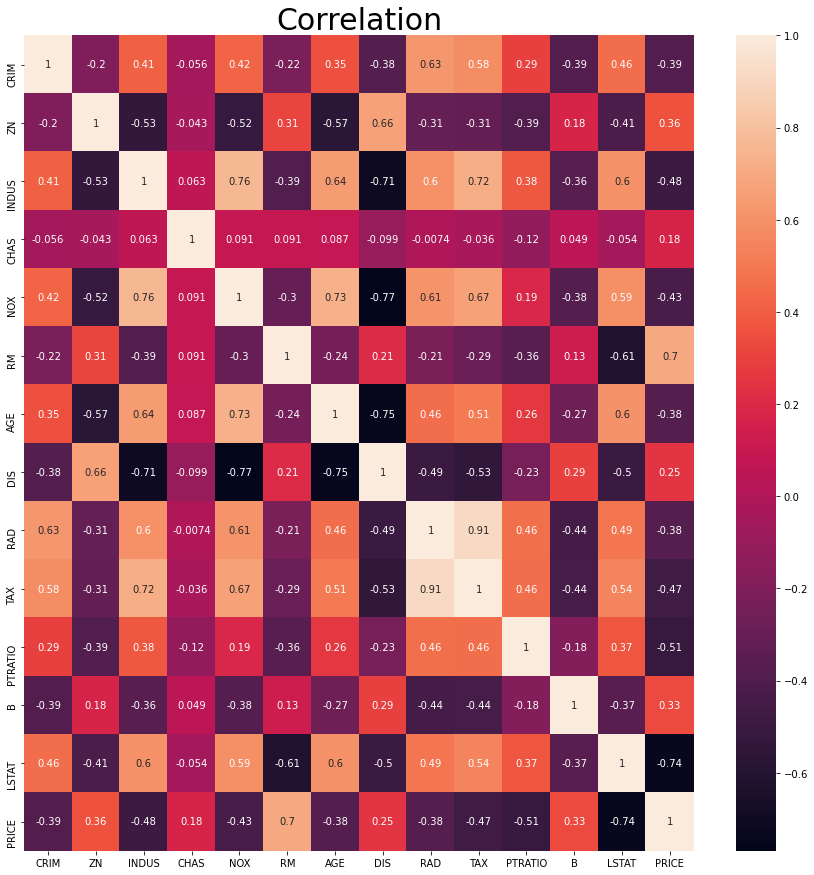

In [13]:
plt.figure(figsize=(15,15))
plt.title('Correlation',fontsize=30)
sns.heatmap(bostonDF.corr(),annot=True)

**학습과 테스트 데이터 세트로 분리하고 학습/예측/평가 수행**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측/평가 수행. 
lr = LinearRegression()
lr.fit(X_train ,y_train )
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


In [4]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164336
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [11]:
print(y_preds[:5].round(1).tolist())
print(y_test[:5].tolist())

[23.2, 19.7, 36.4, 20.0, 32.4]
[21.7, 19.9, 36.5, 12.5, 29.0]


In [5]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index가 컬럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns )
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [6]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시  RMSE 구함. 
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
# scoring 함수에 'neg_mean_squared_error'를 적용해 음수값을 반환하는 이유
# 사이킷런의 지표 평가 기준은 높은 지표 값일수록 좋은 모델인데 반해 일반적으로 
# 회귀는 MSE 값이 낮을수록 좋은 회귀 모델임.
# Scoring 함수가 score값이 클수록 좋은 평가 결과로 자동 평가하므로 -1을 원래의
# 평가 지표 값에 곱해서 음수로 만들어 작은 오류 값이 더 큰 숫자로 인식하게 함
# metrics.mean_absolute_error()와 같은 평가 지표 api는 정상적으로 양수를 반환
# Scoring 파라미터 값 'neg_mean_absolute_error'은 
# -1*metrics.mean_absolute_error()을 의미

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))


 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


#### 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷
- 회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 필요가 있음
- 선형 모형의 비용함수는 RSS(실제 값과 예측값의 차이)를 최소화하는 것만 고려한 결과 테스트 데이터 세트 예측 성능 저하 초래
- RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 서로 균형을 이루게 해야 함(최적모델을 위한 Cost 함수 구성요소 = 학습데이터 잔차 오류 최소화 + 회귀계수 크기 제어)
- 회귀 계수 값의 크기를 조절하기 위하여 비용 함수에 알파 값으로 패널티를 부여해 과적합을 개선하는 방식을 규제라고 함
- alpha값을 크게 하면 비용 함수는 회귀 계수 W의 값을 작게 해 과적합을 개선할 수 있으며 alpha값을 작게 하면 회귀 계수 W의 값이 커져도 어느정도 상쇄가 가능하므로 학습데이터 적합을 더 개선
- 비용함수에 alpha값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제라고 한다.
- 규제는 크게 L2 방식과 L1 방식으로 구분되며 전자를 적용한 회귀를 릿지, 후자를 적용한 것이 라쏘임
- L2는 W의 제곱에 패널티를 부여하며 L1은 W의 절댓값에 패널티 부여
- 엘리스틱넷 회귀는 L2 규제와 L1 규제를 결합한 회귀

In [14]:
# 릿지 회귀
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target,\
                                scoring="neg_mean_squared_error"\
                                ,cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print('5 folds의 개별 Negative MSE scores :', np.round(neg_mse_scores,3))
print('5 folds의 개별 RMSE scores :', np.round(rmse_scores,3))
print('5 folds의 평균 RMSE scores : {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores : [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores : [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE scores : 5.518


In [15]:
alphas = [0, 0.1, 1, 10, 100]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    
    neg_mse_scores = cross_val_score(ridge, X_data, y_target,\
                                    scoring="neg_mean_squared_error"\
                                    ,cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {}일 때 5 folds의 평균 RMSE : {:.3f}'.format(alpha,\
                                                         avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1일 때 5 folds의 평균 RMSE : 5.788
alpha 1일 때 5 folds의 평균 RMSE : 5.653
alpha 10일 때 5 folds의 평균 RMSE : 5.518
alpha 100일 때 5 folds의 평균 RMSE : 5.330


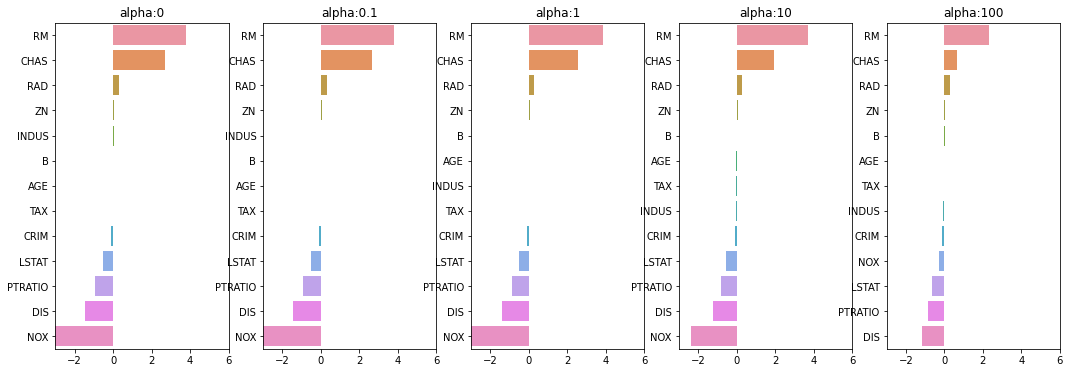

In [16]:
# alpha 값이 증가하면서 회귀 계수가 지속적으로 작아짐
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data,y_target)
    
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])
plt.show() 

In [17]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column,ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


In [18]:
# 라쏘 회귀
from sklearn.linear_model import Lasso, ElasticNet
def get_linear_reg_eval(model_name,params=None,X_data_n=None, 
                        y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name == 'Ridge':model = Ridge(alpha=param)
        elif model_name == 'Lasso':model = Lasso(alpha=param)
        elif model_name == 'ElasticNet':model = ElasticNet(alpha=param, \
                                                          l1_ratio=0.7)
        neg_mse_scores = \
        cross_val_score(model,X_data_n,y_target_n, \
                        scoring="neg_mean_squared_error", cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {}일 때 5 폴드 세트의 평균 RMSE: {:3f}'\
              .format(param, avg_rmse))
        model.fit(X_data,y_target)
        coeff = pd.Series(data=model.coef_, index=X_data.columns)
        colname = 'alpha:'+str(param)
        coeff_df[colname] = coeff
    return coeff_df    

In [19]:
lasso_alphas = [0.07,0.1,0.5,1,3]
coeff_lasso_df = get_linear_reg_eval('Lasso',params=lasso_alphas,\
                                    X_data_n=X_data,y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612284
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615116
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669123
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776021
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.188763


In [20]:
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column,ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


In [21]:
# 엘라스틱넷 회귀
elastic_alphas = [0.07,0.1,0.5,1,3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet',\
                                       params = elastic_alphas,
                                      X_data_n=X_data,\
                                       y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.541654
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.525928
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.466749
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.596874
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068122


In [22]:
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


In [23]:
# 선형 회귀 모델을 위한 데이터 변환
from sklearn.preprocessing import StandardScaler,MinMaxScaler,\
PolynomialFeatures
def get_scaled_data(method='None',p_degree=None, input_data=None):
    if method=='Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    if p_degree != None:
        scaled_data = \
        PolynomialFeatures(degree=p_degree,include_bias=False).\
        fit_transform(scaled_data)
    return scaled_data  

In [24]:
# 결과를 보면 로그 변환 경우에 좋은 성능 향상을 볼 수 있음
# 일반적으로 선형 회귀를 적용하려면 데이터 세트에 데이터 값의 분포가 심하게 왜곡되어 있을 경우에
# 이처럼 로그 변횐을 적용하는 것이 좋은 결과를 기대할 수 있음
alphas = [0.1,1,10,100]
scale_methods=[(None,None),('Standard',None),('Standard',2),
             ('MinMax',None),('MinMax',2),('Log',None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0],
                                   p_degree=scale_method[1],
                                   input_data=X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.\
          format(scale_method[0],scale_method[1]))
    get_linear_reg_eval('Ridge',params=alphas, X_data_n=X_data_scaled,
                       y_target_n=y_target,verbose=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788487
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.652571
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518166
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.329590

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.825993
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.802890
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.636831
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421375

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827236
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871288
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.484870
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634438

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.763570
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465045
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754164
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.634920

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.297560
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.322660
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185204
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.537867

## 변환 유형:Log,